In [1]:
# project source code
import fann
# syntax utils
from typing import Tuple, Dict, Callable, Union
from importlib import reload
# data loading
import sklearn.datasets as datasets
# data structures
import pandas as pd
# calculations and algorithms
import numpy as np
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import sklearn
from sklearn.neural_network import MLPClassifier as RefNN  # reference implementation
# visualization
import matplotlib.pyplot as plt

# utility functions

not important to read every single line of every single one

In [2]:
NUM_FEATURES: int = 2  # aka num of neurons on input layer
NUM_CATEGORIES: int = 2  # aka num of neurons on output layer
LAYER_SZ: Tuple[int] = (4, 3)  # first hidden layer has 4 neurons, second hidden layer has 3 neurons


def lrange(*args) -> list:
    return list(range(*args))


def titlefy(d: str) -> str:
    # e.g. "train" -> "TRAINING DATA"
    return "{d}ing Data".format(d=d).upper()


def gen_data(n: int=256, noise: float=0.32, random_seed: int=1337, x_scaler: object=None) ->\
    (Dict[str, Union[pd.DataFrame, pd.Series]], object):
    X, y = sklearn.datasets.make_moons(n_samples=n, noise=noise, random_state=random_seed)
    assert X.shape[1] == NUM_FEATURES, (len(X), NUM_FEATURES)
    assert len(set(y)) == NUM_CATEGORIES, (len(set(y)), NUM_CATEGORIES)
    x_scaler = sklearn.preprocessing.StandardScaler().fit(X) if x_scaler is None else x_scaler
    X = x_scaler.transform(X)
    X = pd.DataFrame(X)
    y = pd.Series(y)
    data = {"X": X, "y": y}
    return data, x_scaler


def homebrewify(ref_model: RefNN, layer_sz: Tuple[float]=LAYER_SZ) -> fann.NN:
    """Reformat reference implementation weights data structure as homebrew."""
    model = []
    # hidden layers
    # init: in 1st iteration, each neuron on input layer will get weighted & fed into each neuron on 1st hidden layer
    prev_neuron_indices = lrange(NUM_FEATURES)
    for l, sz in enumerate(layer_sz):
        curr_neuron_indices = lrange(sz)
        del sz
        layer = fann.Layer(index=curr_neuron_indices, columns=[fann.BIAS_INDEX] + prev_neuron_indices)
        # populate bias weights
        layer.loc[:, fann.BIAS_INDEX] = ref_model.intercepts_[l]
        # populate non-bias weights
        layer.loc[:, prev_neuron_indices] = ref_model.coefs_[l].T
        del l
        fann.check_layer(layer=layer)
        model.append(layer)
        del layer
        # in next iteration, each neuron on this layer will get weighted & fed into each neuron on next layer
        prev_neuron_indices = curr_neuron_indices
        del curr_neuron_indices
    model = pd.concat(model, keys=lrange(len(layer_sz)))
    fann.check_nn(nn=model)
    # output layer.
    """
    sklearn uses single output neuron & predicts category label
    (0 or 1) based on whether its activation < or >= 0.50..
    we use 2 output neurons & predict category label
    (0 or 1) based on whose activation is stronger.
    hence, in replicating sklearn's model,
    we make our first output neuron (0) a dummy whose activation is
    always exactly equal to the complement probability of
    the second output neuron (1) activation.
    (note: this means we don't need to "squash" our output
    before assigning probabilities to category labels,
    or making a final prediction: our output is "pre-squashed".
    of course, because our code doesn't know this,
    it will squash anyway, but because `exp()` is a
    strictly increasing function, the squashing won't have any effect
    on which category we ultimately predict.)
    using the single row index `-1` for ref model
    would apply even to multinomial classification,
    since it simply extracts ref model's last i.e. output layer.
    but, using the single column index (`0` for ref model,
    and `0` or `1` for homebrew model)
    is the part that assumes this is binary classification,
    since it assumes there are only 2 categories in the output layer.
    """
    if NUM_CATEGORIES != 2:
        raise ValueError("In this last step, I'm assuming binary classification!")
    # populate bias weight (both output neurons should have same bias aka "center"..)
    model.loc[pd.IndexSlice[len(layer_sz), 0], fann.BIAS_INDEX] = ref_model.intercepts_[-1][0]
    model.loc[pd.IndexSlice[len(layer_sz), 1], fann.BIAS_INDEX] = ref_model.intercepts_[-1][0]
    # populate non-bias weights (.. but opposite feed-in weights)
    model.loc[pd.IndexSlice[len(layer_sz), 0], prev_neuron_indices] = -ref_model.coefs_[-1].T[0]
    model.loc[pd.IndexSlice[len(layer_sz), 1], prev_neuron_indices] = ref_model.coefs_[-1].T[0]
    del prev_neuron_indices
    del layer_sz
    fann.check_nn(nn=model)
    return model


def plot_data(X: pd.DataFrame, y: pd.Series, title: str=None, ax: plt.matplotlib.axes._base._AxesBase=None) ->\
    type(None):
    ax = plt if ax is None else ax
    # caution: in scatterplot, `x` is actually X[0] i.e. the 1st feature, `y` is X[1] i.e. 2nd feature
    ax.scatter(x=X[0], y=X[1], c=y, cmap=plt.cm.coolwarm)
    try:
        ax.set_title(title)
    except AttributeError:
        ax.title(title)
    if ax == plt:
        ax.show()


def plot_datas(X0: pd.DataFrame, y0: pd.Series, X1: pd.DataFrame, y1: pd.Series,
               title0: str=None, title1: str=None, suptitle: str=None) -> type(None):
    _, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
    plot_data(X=X0, y=y0, title=title0, ax=axs[0])
    plot_data(X=X1, y=y1, title=title1, ax=axs[1])
    if suptitle is not None:
        plt.suptitle(suptitle)
    plt.show()
    
    
def plot_perf(X: pd.DataFrame, y: pd.Series, y_hat: pd.Series, suptitle: str=None) -> type(None):
    score = np.mean(y_hat == y)
    plot_datas(X0=X, y0=y, title0="Ground Truth",
               X1=X, y1=y_hat, title1="Model (score = {score:.2f}%)".format(score=score * 100),
               suptitle=suptitle)


def plot_perfs(pred_fn: Callable[[pd.DataFrame], pd.Series]) -> type(None):
    for d in "train", "test":
        plot_perf(X=data[d]["X"], y=data[d]["y"], y_hat=pred_fn(data[d]["X"]), suptitle=titlefy(d=d))

# construct datasets

In [3]:
data = {}
data["train"], x_scaler = gen_data()
# for simplicity, we pretend we know ground-truth optimal hyperparameters -> don't need tuning data
# data["Tuning Data"], _ = gen_data(random_seed=1337+1, x_scaler=x_scaler)
data["test"], _ = gen_data(random_seed=1337+2, x_scaler=x_scaler)

In [4]:
# preview
d = "train"
pd.concat([data[d]["X"], data[d]["y"]], axis="columns", keys=["X", "y"])

X            y
            0         1  0
0   -1.720010 -0.592602  0
1   -0.263360  1.315617  0
2   -0.811233  0.593363  0
3    0.108340  1.623423  0
4   -0.252440 -0.046977  1
..        ...       ... ..
251  0.370235 -1.117875  1
252  1.783155 -0.707722  1
253 -1.453746  0.273004  0
254  1.045813 -0.978903  1
255 -0.767574 -0.051766  1

[256 rows x 3 columns]

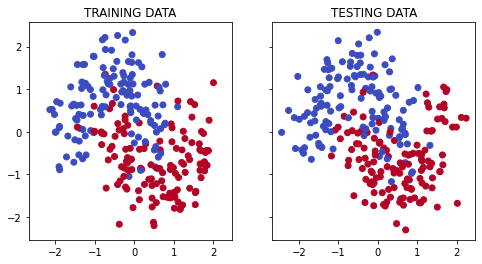

In [5]:
d0, d1 = "train", "test"
plot_datas(X0=data[d0]["X"], y0=data[d0]["y"], title0=titlefy(d=d0),
           X1=data[d1]["X"], y1=data[d1]["y"], title1=titlefy(d=d1))
del d0, d1

# "cheat" off a reference model

In [6]:
d = "train"
ref_model = RefNN(hidden_layer_sizes=LAYER_SZ, activation="logistic",
                  solver="lbfgs", max_iter=2048, random_state=1337).fit(X=data[d]["X"], y=data[d]["y"])
del d

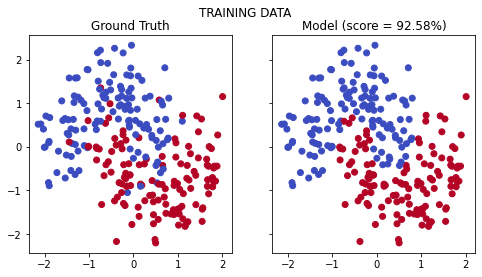

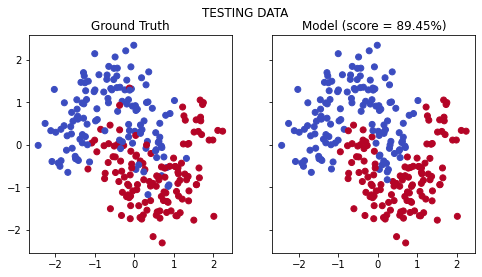

In [7]:
plot_perfs(pred_fn=ref_model.predict)

## replicate

In [8]:
model = homebrewify(ref_model=ref_model)
model

_bias_          0          1          2          3
0 0   0.873385   3.944629  -0.841650        NaN        NaN
  1  22.316308 -12.993556  16.603979        NaN        NaN
  2 -25.552951  30.081200 -11.800556        NaN        NaN
  3  -1.068344   4.525354  -0.518800        NaN        NaN
1 0 -25.782396  -9.737237  25.080410 -40.164008  51.412467
  1  25.630496  18.716913 -33.278286  50.685572  -9.136564
  2  15.599658   7.432398  -6.167783  11.372810  -1.191241
2 0   3.980336  74.614951 -54.646973 -16.600309        NaN
  1   3.980336 -74.614951  54.646973  16.600309        NaN

In [9]:
""" from above:
sklearn uses single output neuron & predicts category label
(0 or 1) based on whether its activation < or >= 0.50..
we use 2 output neurons & predict category label
(0 or 1) based on whose activation is stronger.
hence, in replicating sklearn's model,
we make our first output neuron (0) a dummy whose activation is
always exactly equal to the complement probability of
the second output neuron (1) activation.
(note: this means we don't need to "squash" our output
before assigning probabilities to category labels,
or making a final prediction: our output is "pre-squashed".
of course, because our code doesn't know this,
it will squash anyway, but because `exp()` is a
strictly increasing function, the squashing won't have any effect
on which category we ultimately predict.)
using the single row index `-1` for ref model
would apply even to multinomial classification,
since it simply extracts ref model's last i.e. output layer.
but, using the single column index (`0` for ref model,
and `0` or `1` for homebrew model)
is the part that assumes this is binary classification,
since it assumes there are only 2 categories in the output layer.
"""
# the following checks "prove" that we did the arithmetic correctly
for d in "train", "test":
    fann.fprop_(X=data[d]["X"], nn=model).apply(fann.check_pmf, axis="columns")
    del d

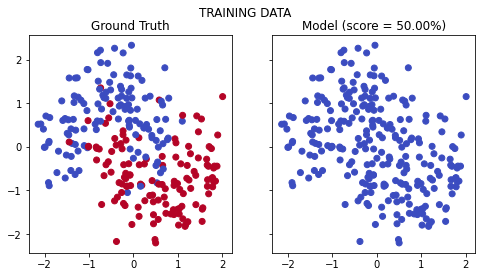

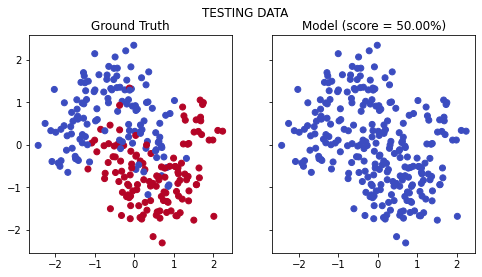

In [10]:
plot_perfs(pred_fn=lambda X: fann.predict(X=X, nn=model))

# `TODO(sparshsah)`

- create check-and-process utils (e.g. `check_bias(w_neuron)`, `concat_to_nn(nn_layers)`)
- more consistent checking of inputs/intermediate values
- language in homebrewify fun
- write unit tests
- why don't we exactly replicate sklearn's predictions?
- write backprop
- train our own homebrew model from scratch
- final style check: no magic numbers, error msgs are informational, constants/functions are type-hinted, docstrings are complete, multi-line comments are triple-quoted strings, line lens <= 120char